In [1]:
# print(df5.fraud_bool.value_counts())
# Original Data Set counts

# 0    988970
# 1     11030
# Name: fraud_bool, dtype: int64

#### TODO
#### 1. Let us use Variant 5 (done)
#### 2. Decided to exclude x1 and x2 (done)
#### 3. Provide rationale for excluding x1 and x2 (To Be Done)
#### 4. Add runtime nb_black / modify anything required (done)
#### 5. Optimize vanilla GaussianNB and RandomForest Classifier (done)
#### 6. ML Performance with default parameters for PATECTGAN , DPGAN and QUAIL (In Progress)
#### 7. Configure QUAIL (configured but not yet trained)
#### 8. Hyperparamter Tuning for DPGAN (To be done)
#### 9. Loss function Plot (To be done)
#### 10. Distributional Similarity Plot (In progress /)
#### 11. ML Utility Code (done - refer DiffPriv_v3)
#### 12. pMSE code (done - refer DiffPriv_v3)
#### 13. Experimental Setup & Result compare Template (To be done)
#### 14. Compare methodology (Descriptive) (To be done)
#### 15. Before (Done) and After Coorelation plot (To be done)
#### 16. Cut a smaller dataset with less no. of features (done)
#### 17. Ensure each synth has a differnt name (done)
#### 18. Import this to collab and train (Ignore)
#### 19. Configure Tabletransformer and set preprocessor eps to zero (Done)

In [2]:
# Code starts here

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [65]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# from sklearn.metrics import r2_curve
from sklearn.metrics import r2_score, roc_curve

# from rfpimp import permutation_importance

import matplotlib.pyplot as plt

# import pandas as pd
from snsynth import Synthesizer
from snsynth.pytorch.nn import PATECTGAN
from snsynth.pytorch import PytorchDPSynthesizer

%config InlineBackend.figure_format = 'retina'
import seaborn as sns

<IPython.core.display.Javascript object>

In [5]:
# Method to evaluate performance
def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_probs = clf.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_probs[:, 1])
    print("ROC AUC Score {}".format(roc_score))

    rf_fpr, rf_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.title("ROC Plot")
    plt.plot(rf_fpr, rf_tpr, "b", marker=".", label="Test, AUC= %0.2f" % roc_score)
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True Positive rate")
    plt.xlabel("False Positive Rate")
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
# Feature importance by reducing Impurity
def plotFeatureImportance(title, clf, plt, features):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=features)
    print(forest_importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importance Using {} data".format(title))
    ax.set_ylabel("Mean decrease in Impurity")
    fig.tight_layout()

<IPython.core.display.Javascript object>

In [7]:
# Plot Feature Importance by Importance
def plotFeatureImportanceByValue(title, clf, plt, features):
    featureList = []
    for feat, importance in zip(features, clf.feature_importances_):
        running_feature = [feat, importance]
        featureList.append(running_feature)
    dfFeature = pd.DataFrame(featureList, columns=["feature", "importance"])
    dfFeature = dfFeature.sort_values(by=["importance"], ascending=False)
    dfFeature.plot(x="feature", y="importance", kind="bar")
    plt.title("Feature importance of {} data by importance".format(title))
    plt.xlabel("Feature")
    plt.xlabel("Importance")
    plt.show()

<IPython.core.display.Javascript object>

In [8]:
seed = 42
epsilon = 40.0

<IPython.core.display.Javascript object>

In [9]:
dfPrivate = pd.read_csv("data/Variant_5.csv")
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 34)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,x1,x2
0,0,0.1,0.054656,-1,55,50,0.029642,-0.779957,AB,1735,...,0,INTERNET,5.063178,linux,0,1,0,2,-0.833286,-0.239018
1,0,0.2,0.516874,-1,178,50,0.036917,-0.471011,AB,910,...,0,INTERNET,5.403648,linux,0,1,0,3,-0.044042,1.174898
2,0,0.1,0.870572,-1,26,30,11.838249,51.068616,AA,1730,...,0,INTERNET,6.701977,linux,1,1,0,2,2.094070,0.643121
3,0,0.1,0.234248,29,9,20,0.030793,16.341333,AA,533,...,0,INTERNET,12.787474,linux,1,1,0,7,-1.060523,0.285319
4,0,0.2,0.909504,11,5,30,0.036117,-1.151589,AB,2935,...,0,INTERNET,4.670977,linux,0,1,0,2,1.989430,-0.803668


<IPython.core.display.Javascript object>

In [10]:
dfPrivate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

<IPython.core.display.Javascript object>

In [11]:
print(dfPrivate.payment_type.value_counts())
print(dfPrivate.employment_status.value_counts())
print(dfPrivate.housing_status.value_counts())
print(dfPrivate.source.value_counts())
print(dfPrivate.device_os.value_counts())

AB    399073
AA    249581
AC    246596
AD    104489
AE       261
Name: payment_type, dtype: int64
CA    685037
CB    134222
CC     89437
CF     45225
CD     26963
CE     18653
CG       463
Name: employment_status, dtype: int64
BC    336096
BB    301948
BA    214920
BE    118602
BD     26533
BF      1664
BG       237
Name: housing_status, dtype: int64
INTERNET    992330
TELEAPP       7670
Name: source, dtype: int64
linux        337150
windows      304492
other        299948
macintosh     50226
x11            8184
Name: device_os, dtype: int64


<IPython.core.display.Javascript object>

In [12]:
cat_cols = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]
le = LabelEncoder()
dfPrivate["payment_type"] = le.fit_transform(dfPrivate["payment_type"])
dfPrivate["employment_status"] = le.fit_transform(dfPrivate["employment_status"])
dfPrivate["housing_status"] = le.fit_transform(dfPrivate["housing_status"])
dfPrivate["source"] = le.fit_transform(dfPrivate["source"])
dfPrivate["device_os"] = le.fit_transform(dfPrivate["device_os"])
# dfPrivate["fraud_bool"] = dfPrivate["fraud_bool"].astype("category")
# for col in cat_cols:
# dfPrivate[str(col)] = le.fit_transform(str(dfPrivate[col]))

<IPython.core.display.Javascript object>

In [13]:
print(dfPrivate.isnull().values.any())
print("---------------------------------------------------")
print(dfPrivate.isna().any())

False
---------------------------------------------------
fraud_bool                          False
income                              False
name_email_similarity               False
prev_address_months_count           False
current_address_months_count        False
customer_age                        False
days_since_request                  False
intended_balcon_amount              False
payment_type                        False
zip_count_4w                        False
velocity_6h                         False
velocity_24h                        False
velocity_4w                         False
bank_branch_count_8w                False
date_of_birth_distinct_emails_4w    False
employment_status                   False
credit_risk_score                   False
email_is_free                       False
housing_status                      False
phone_home_valid                    False
phone_mobile_valid                  False
bank_months_count                   False
has_other_cards   

<IPython.core.display.Javascript object>

In [14]:
all_cols = dfPrivate.columns.tolist()
print(len(all_cols))
cols_excluded = ["x1", "x2"]
features_selected = [x for x in all_cols if x not in cols_excluded]
print(len(features_selected))
print(features_selected)

34
32
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'employment_status', 'credit_risk_score', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source', 'session_length_in_minutes', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


<IPython.core.display.Javascript object>

In [15]:
# Create Correlation Plot for feature selection

<IPython.core.display.Javascript object>

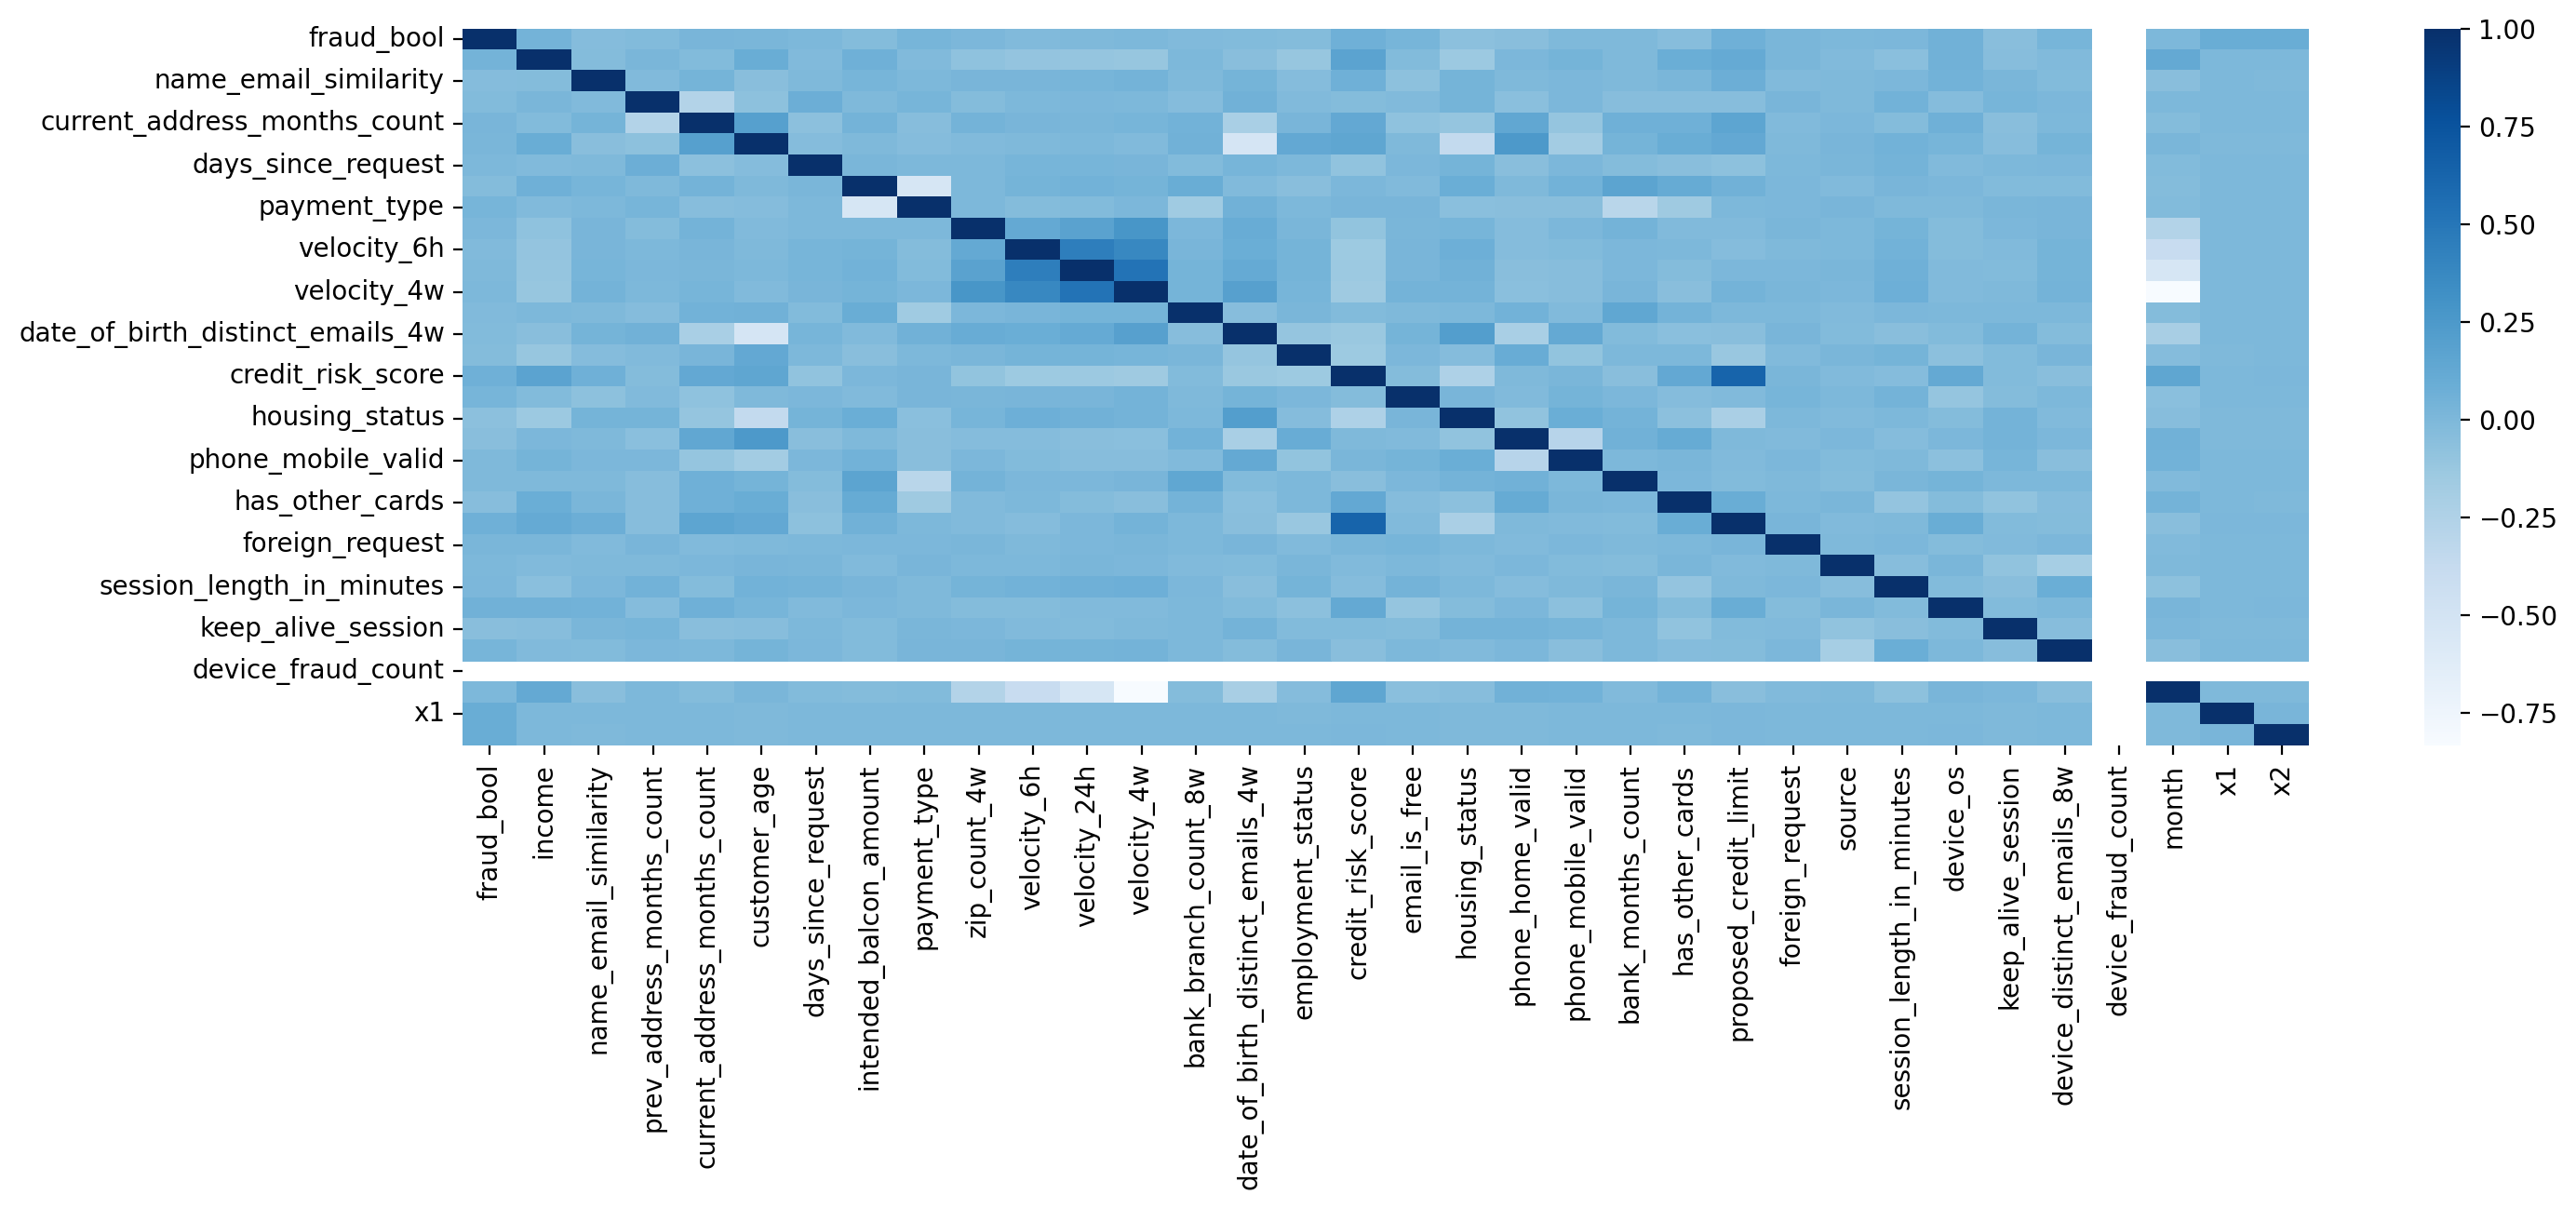

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(16, 5))
corr = dfPrivate.corr()
ax = sns.heatmap(corr, cmap="Blues", annot=False)

In [17]:
dfPrivate = dfPrivate[features_selected]
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.1,0.054656,-1,55,50,0.029642,-0.779957,1,1735,...,0,200.0,0,0,5.063178,0,0,1,0,2
1,0,0.2,0.516874,-1,178,50,0.036917,-0.471011,1,910,...,0,200.0,0,0,5.403648,0,0,1,0,3
2,0,0.1,0.870572,-1,26,30,11.838249,51.068616,0,1730,...,1,200.0,0,0,6.701977,0,1,1,0,2
3,0,0.1,0.234248,29,9,20,0.030793,16.341333,0,533,...,0,200.0,0,0,12.787474,0,1,1,0,7
4,0,0.2,0.909504,11,5,30,0.036117,-1.151589,1,2935,...,1,200.0,0,0,4.670977,0,0,1,0,2


<IPython.core.display.Javascript object>

In [18]:
# dfPrivate.corr().iloc[:-1,-1]
print(np.corrcoef(dfPrivate[dfPrivate.columns[:]].T)[-1][:-1])

[ 0.0027703   0.1246379  -0.04551496 -0.00154753 -0.02812459  0.01525461
 -0.02146303 -0.02824374 -0.0198709  -0.26639213 -0.39261882 -0.53034329
 -0.83308907 -0.02967822 -0.19592044 -0.03238269  0.15471359 -0.05267655
 -0.04457806  0.06010688  0.04899316 -0.01252018  0.04141463 -0.05084225
 -0.01049715 -0.0064131  -0.07298938  0.01979079  0.00519772 -0.05095431
         nan]


<IPython.core.display.Javascript object>

In [19]:
print(dfPrivate[dfPrivate.columns[:]].corr()["fraud_bool"])

fraud_bool                          1.000000
income                              0.041016
name_email_similarity              -0.031502
prev_address_months_count          -0.022450
current_address_months_count        0.023834
customer_age                        0.018788
days_since_request                  0.003553
intended_balcon_amount             -0.023989
payment_type                        0.031470
zip_count_4w                        0.008753
velocity_6h                        -0.012831
velocity_24h                       -0.005003
velocity_4w                        -0.002470
bank_branch_count_8w               -0.014682
date_of_birth_distinct_emails_4w   -0.019157
employment_status                  -0.027289
credit_risk_score                   0.068499
email_is_free                       0.029273
housing_status                     -0.066345
phone_home_valid                   -0.047340
phone_mobile_valid                 -0.005265
bank_months_count                  -0.005320
has_other_

<IPython.core.display.Javascript object>

In [20]:
dfPrivate.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

<IPython.core.display.Javascript object>

In [21]:
final_feature_selected = [
    "fraud_bool",
    "income",
    "name_email_similarity",
    "payment_type",
    "employment_status",
    "credit_risk_score",
    "housing_status",
    "phone_home_valid",
    "has_other_cards",
    "proposed_credit_limit",
    "device_os",
    "keep_alive_session",
]

<IPython.core.display.Javascript object>

In [22]:
dfPrivate = dfPrivate[final_feature_selected]
print(dfPrivate.shape)
dfPrivate.head()

(1000000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.1,0.054656,1,2,74,1,1,0,200.0,0,0
1,0,0.2,0.516874,1,2,164,1,1,0,200.0,0,0
2,0,0.1,0.870572,0,0,169,2,0,1,200.0,0,1
3,0,0.1,0.234248,0,0,75,2,1,0,200.0,0,1
4,0,0.2,0.909504,1,1,129,1,0,1,200.0,0,0


<IPython.core.display.Javascript object>

In [23]:
print(dfPrivate[dfPrivate.columns[:]].corr()["fraud_bool"])

fraud_bool               1.000000
income                   0.041016
name_email_similarity   -0.031502
payment_type             0.031470
employment_status       -0.027289
credit_risk_score        0.068499
housing_status          -0.066345
phone_home_valid        -0.047340
has_other_cards         -0.038587
proposed_credit_limit    0.067985
device_os                0.056967
keep_alive_session      -0.050665
Name: fraud_bool, dtype: float64


<IPython.core.display.Javascript object>

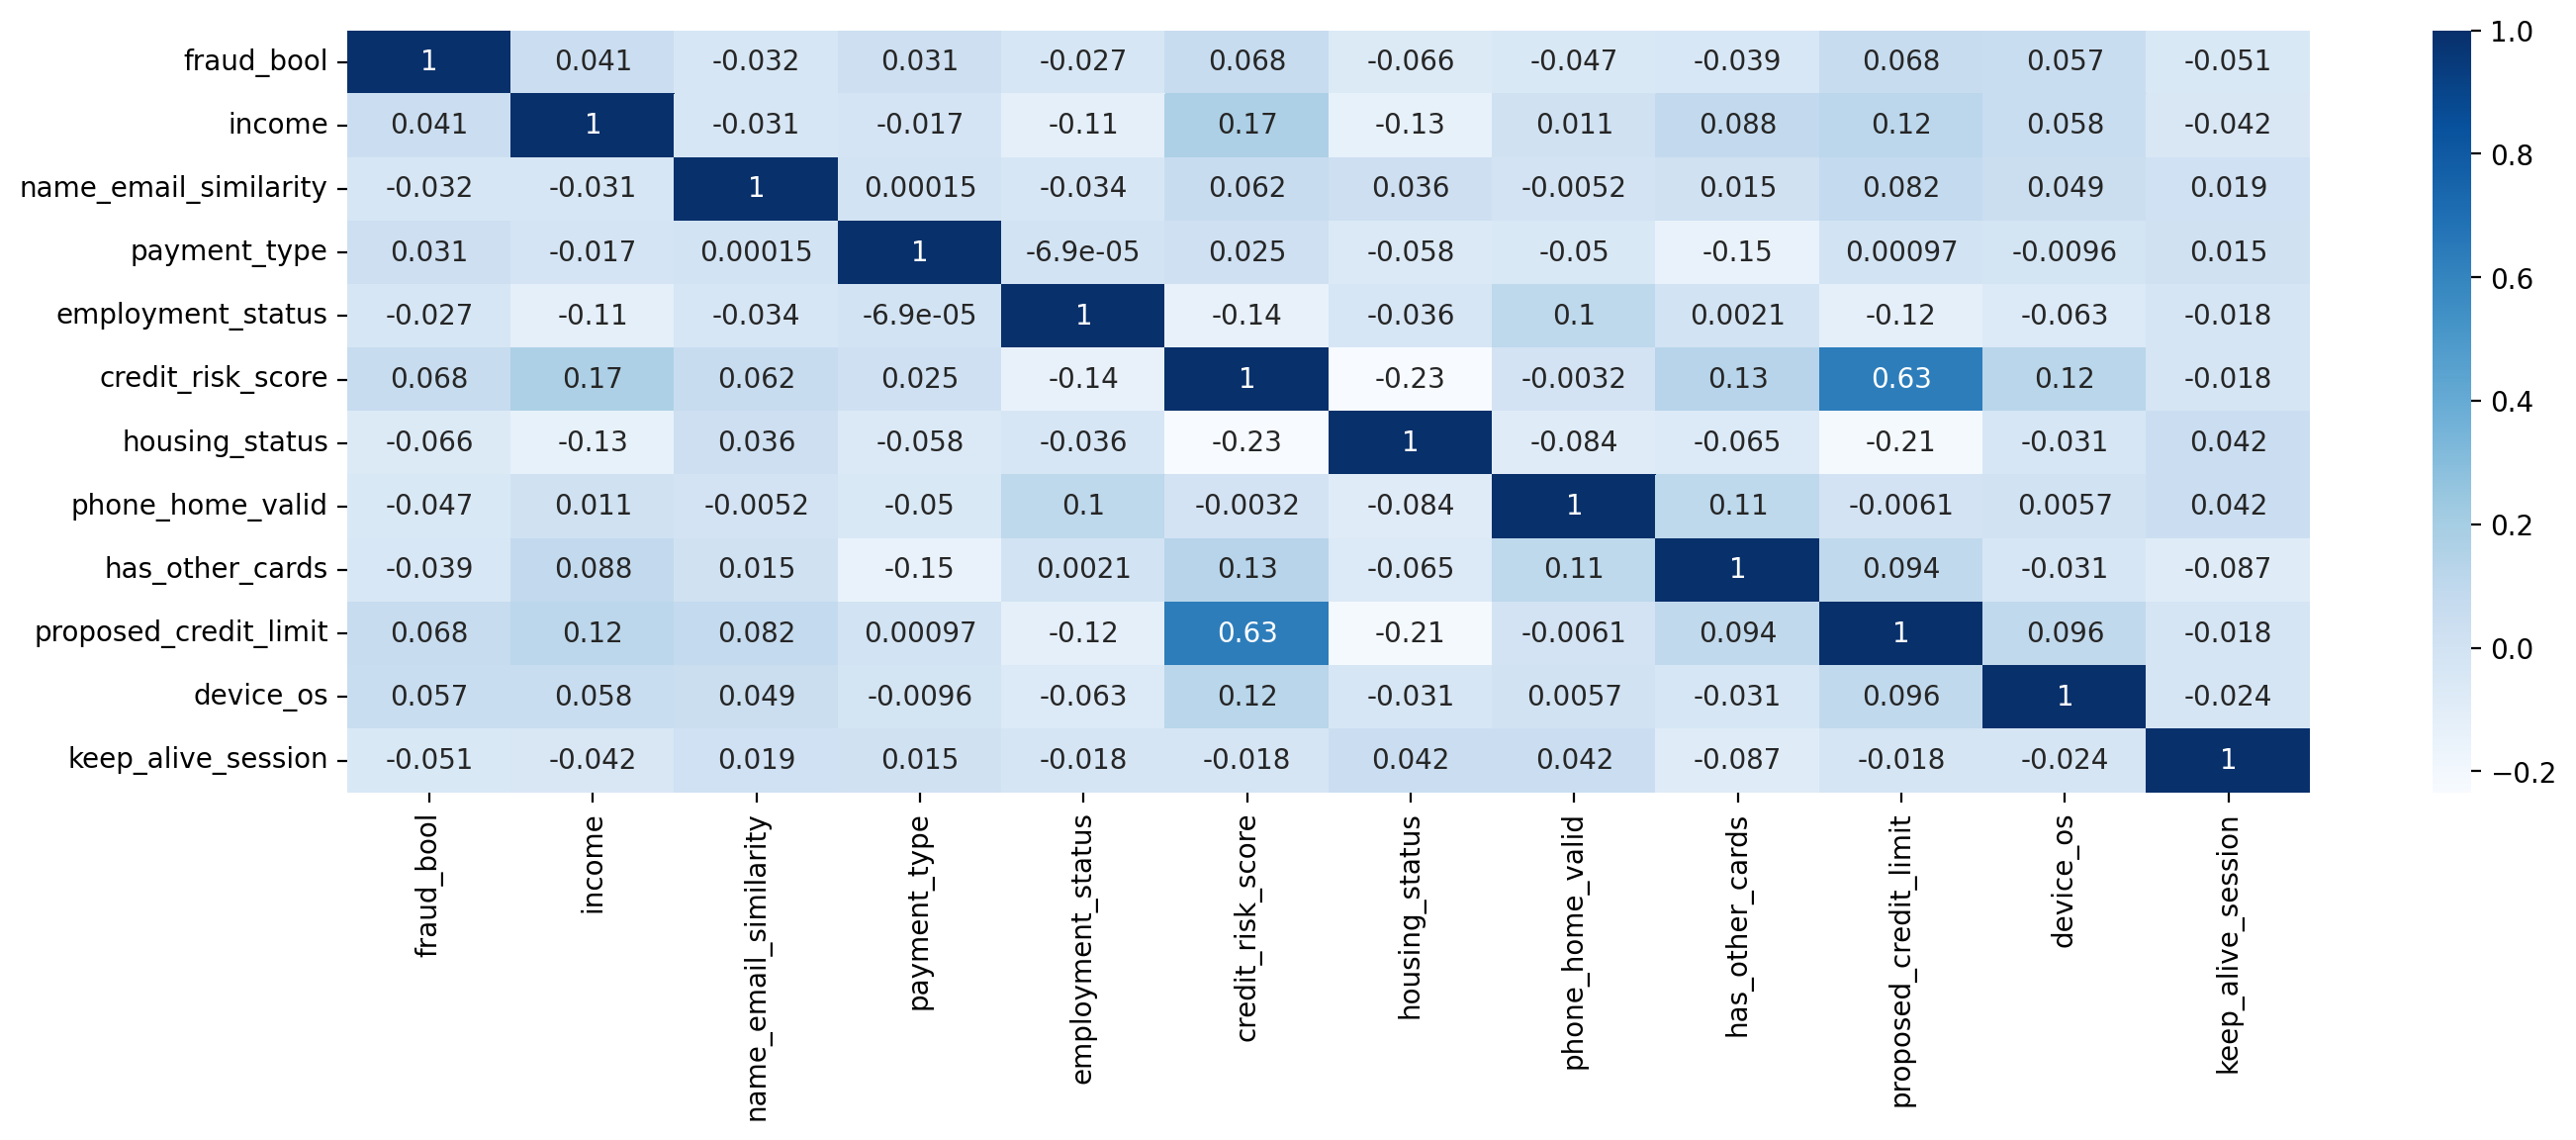

<IPython.core.display.Javascript object>

In [24]:
plt.figure(figsize=(16, 5))
corr = dfPrivate.corr()
ax = sns.heatmap(corr, cmap="Blues", annot=True)

In [25]:
Xy_train, Xy_test = train_test_split(
    dfPrivate, test_size=0.3, stratify=dfPrivate["fraud_bool"], random_state=seed
)
print(Xy_train.shape, Xy_test.shape)
display(Xy_train.head())
display(Xy_test.head())

(700000, 12) (300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
336722,0,0.9,0.323914,2,0,85,0,1,0,200.0,3,1
602823,0,0.8,0.520927,1,5,180,2,0,0,200.0,3,0
236576,0,0.9,0.086442,1,0,269,1,1,1,1500.0,3,1
271511,0,0.9,0.779473,0,0,152,2,0,0,200.0,3,0
77499,0,0.6,0.344351,0,0,187,2,1,1,1500.0,0,0


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
872009,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
638219,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
661244,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
146925,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
748341,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


<IPython.core.display.Javascript object>

In [26]:
# Make Test Set as Target set
Xy_test["fraud_bool"].value_counts()


0    296691
1      3309
Name: fraud_bool, dtype: int64

<IPython.core.display.Javascript object>

In [27]:
print((3309 / 300000) * 100)
print((11030 / 1000000) * 100)

1.103
1.103


<IPython.core.display.Javascript object>

In [28]:
dfPrivate = Xy_test.copy()
dfPrivate.reset_index(drop=True, inplace=True)
print(dfPrivate.shape)
dfPrivate.head()

(300000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.4,0.208878,2,5,160,2,1,0,200.0,0,1
1,0,0.8,0.993504,1,1,197,0,0,0,1500.0,3,1
2,0,0.8,0.265069,1,0,163,2,0,1,500.0,0,1
3,0,0.1,0.263270,1,0,193,2,1,0,200.0,3,1
4,0,0.3,0.438486,1,2,41,1,0,1,200.0,2,0


<IPython.core.display.Javascript object>

In [29]:
Xy_train, Xy_test = train_test_split(
    dfPrivate, test_size=0.3, stratify=dfPrivate["fraud_bool"], random_state=seed
)
print(Xy_train.shape, Xy_test.shape)
display(Xy_train.head())
display(Xy_test.head())

(210000, 12) (90000, 12)


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
30628,0,0.5,0.892307,0,1,84,2,0,1,1500.0,3,0
205000,0,0.8,0.750793,0,0,165,1,1,1,1500.0,0,1
150790,0,0.6,0.479703,0,0,128,1,0,1,200.0,2,1
46427,0,0.9,0.992241,0,0,136,0,1,0,200.0,0,1
136541,0,0.8,0.183352,0,0,183,2,1,0,500.0,0,1


,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
257637,0,0.9,0.857262,1,0,160,0,1,0,500.0,3,0
152544,0,0.6,0.336738,2,1,232,0,0,1,1500.0,3,0
272643,0,0.4,0.739320,0,0,-50,4,0,0,1500.0,3,0
232300,0,0.8,0.999637,3,0,167,1,0,0,200.0,3,0
124255,0,0.9,0.010020,2,1,200,0,0,0,1500.0,3,1


<IPython.core.display.Javascript object>

In [30]:
scaler = StandardScaler()
feature_normalized = [x for x in final_feature_selected if x not in ["fraud_bool"]]
Xy_train.loc[:, feature_normalized] = scaler.fit_transform(
    Xy_train.loc[:, feature_normalized]
)
Xy_test.loc[:, feature_normalized] = scaler.fit_transform(
    Xy_test.loc[:, feature_normalized]
)

<IPython.core.display.Javascript object>

In [31]:
X_train = Xy_train.drop("fraud_bool", axis=1)
y_train = Xy_train["fraud_bool"]

X_test = Xy_test.drop("fraud_bool", axis=1)
y_test = Xy_test["fraud_bool"]

<IPython.core.display.Javascript object>

In [32]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(210000, 11) (210000,) (90000, 11) (90000,)


<IPython.core.display.Javascript object>

In [33]:
# persist
print(dfPrivate.shape)
dfPrivate.to_csv("data/output/dfPrivate.csv", index=False)

(300000, 12)


<IPython.core.display.Javascript object>

In [34]:
X_test.to_csv("data/output/X_test.csv", index=False)
y_test.to_csv("data/output/y_test.csv", index=False)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     89007
           1       0.30      0.01      0.02       993

    accuracy                           0.99     90000
   macro avg       0.65      0.50      0.51     90000
weighted avg       0.98      0.99      0.98     90000

ROC AUC Score 0.7449041059501855


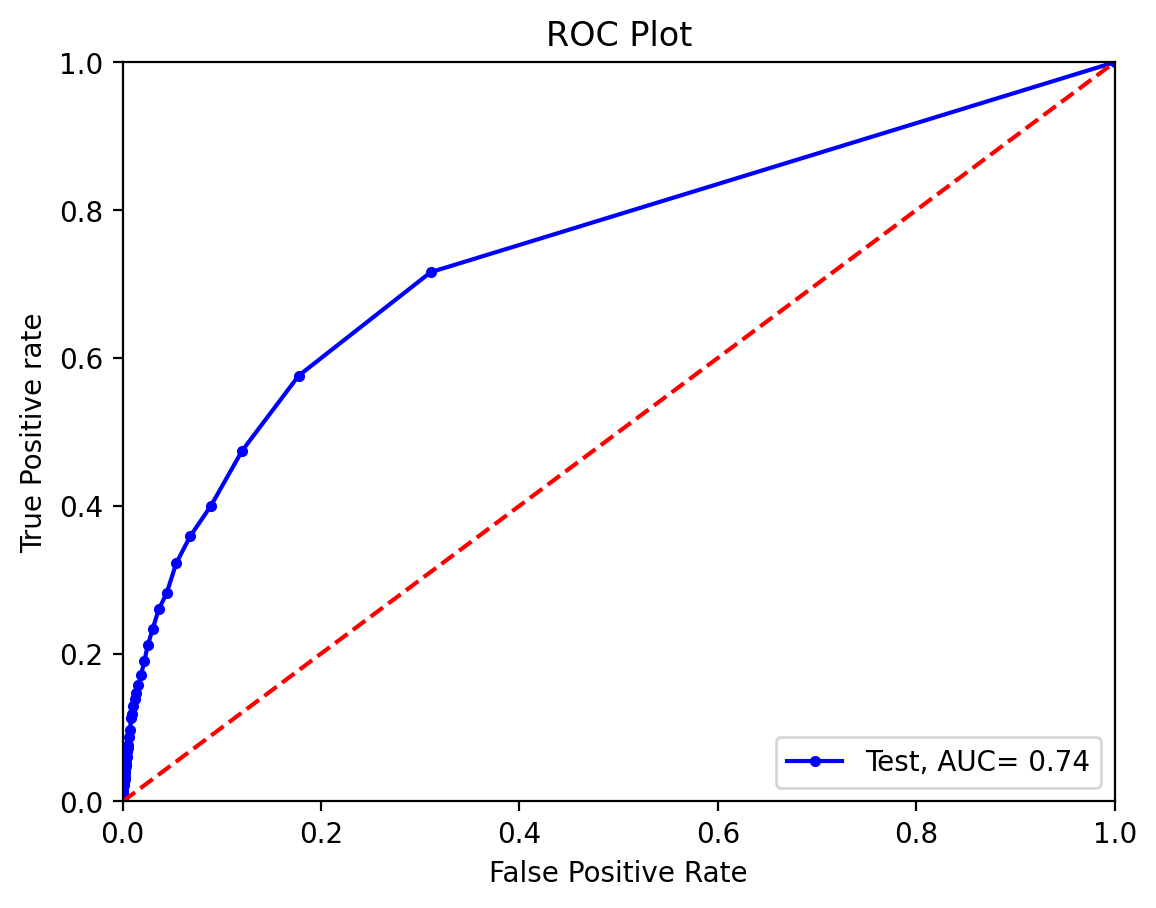

<IPython.core.display.Javascript object>

In [35]:

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     89007
           1       0.13      0.16      0.15       993

    accuracy                           0.98     90000
   macro avg       0.56      0.58      0.57     90000
weighted avg       0.98      0.98      0.98     90000

ROC AUC Score 0.810427110234074


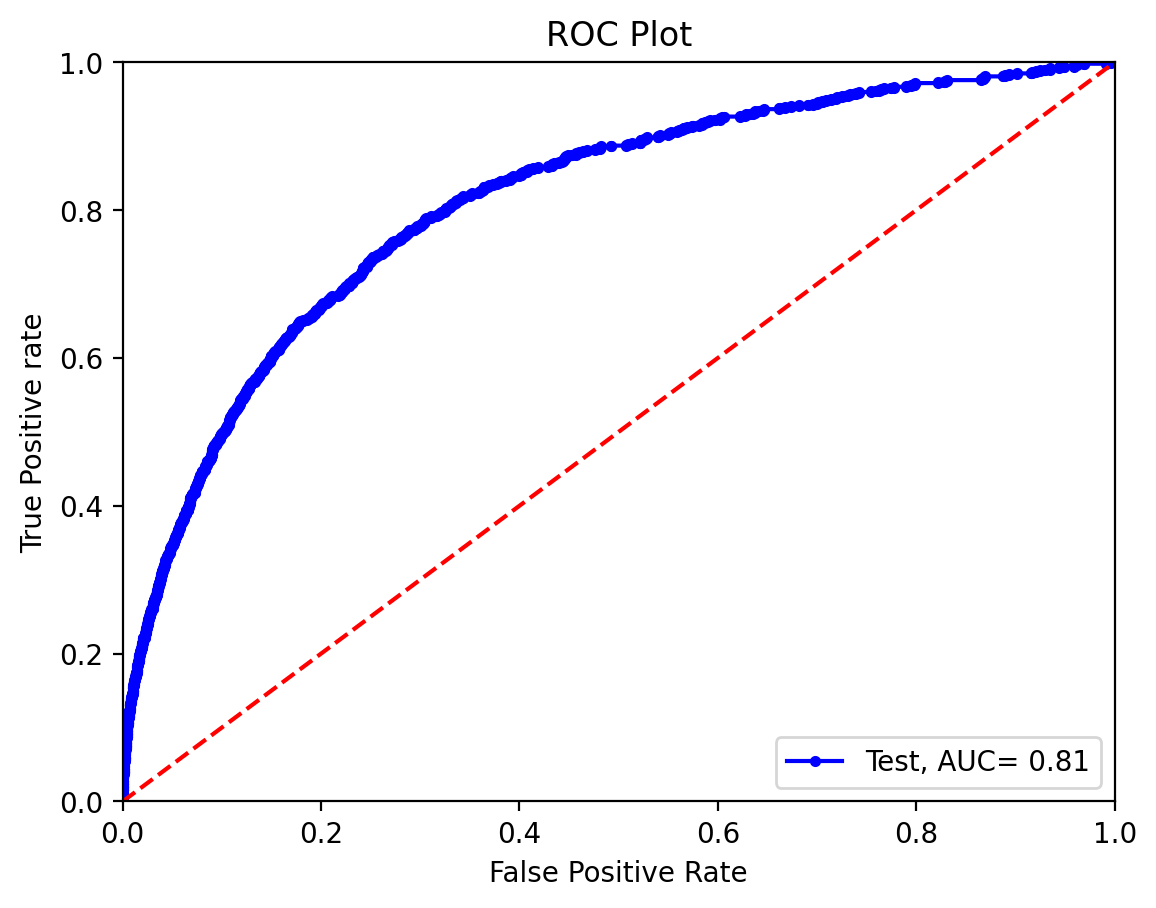

<IPython.core.display.Javascript object>

In [36]:
# Taking a lot of time - optimize it

from sklearn.naive_bayes import GaussianNB

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

evaluate(clf_NB, X_test, y_test)


In [37]:
features_selected_witout_target = [
    x for x in final_feature_selected if x not in ["fraud_bool"]
]

<IPython.core.display.Javascript object>

income                   0.075621
name_email_similarity    0.381659
payment_type             0.053386
employment_status        0.034471
credit_risk_score        0.297316
housing_status           0.033092
phone_home_valid         0.013890
has_other_cards          0.012571
proposed_credit_limit    0.054819
device_os                0.030818
keep_alive_session       0.012358
dtype: float64


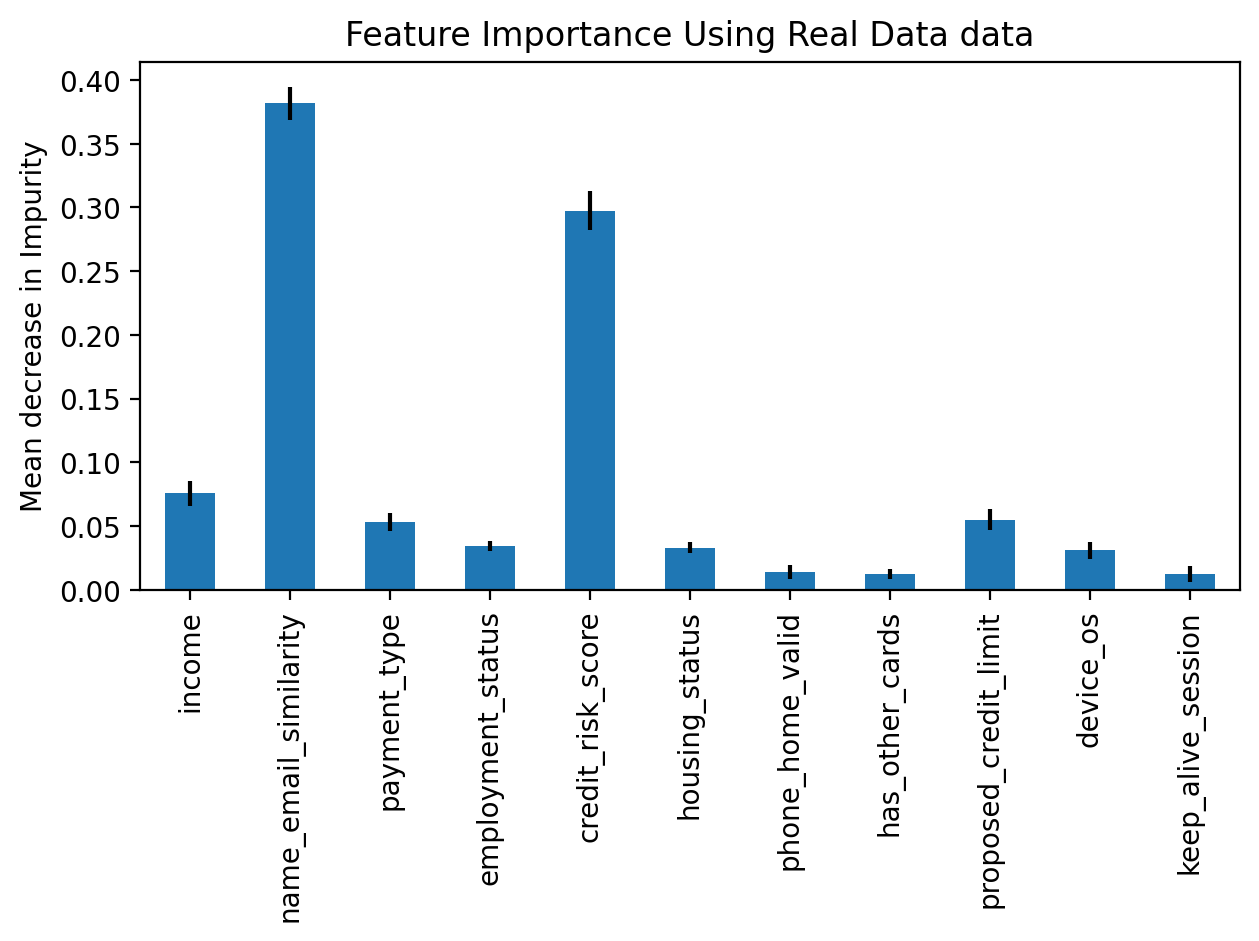

<IPython.core.display.Javascript object>

In [38]:
plotFeatureImportance("Real Data", clf, plt, features_selected_witout_target)

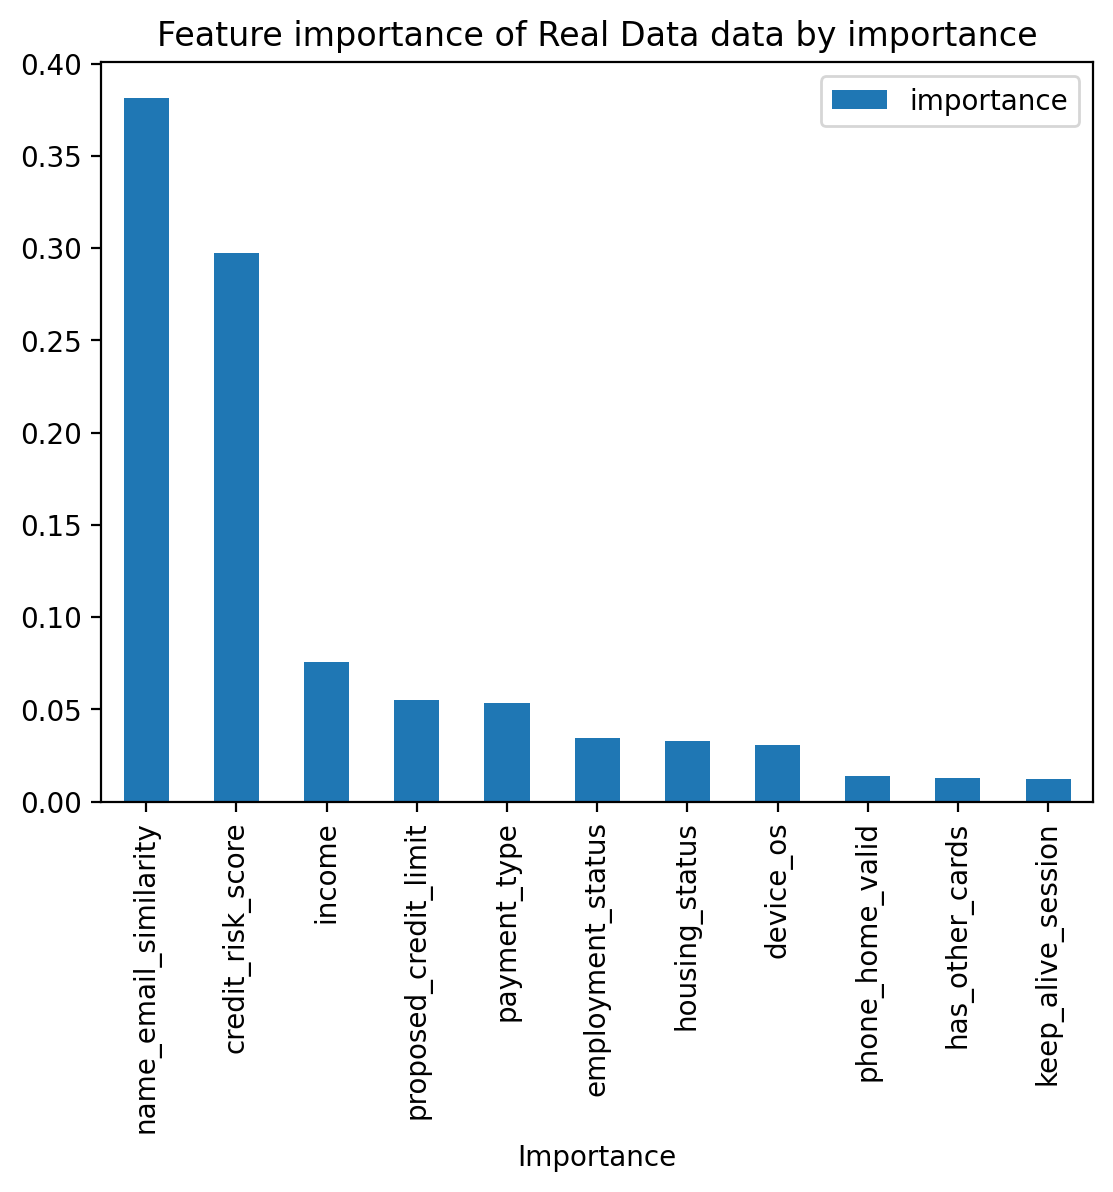

<IPython.core.display.Javascript object>

In [39]:
plotFeatureImportanceByValue("Real Data", clf, plt, features_selected_witout_target)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     89007
           1       0.00      0.00      0.00       993

    accuracy                           0.99     90000
   macro avg       0.49      0.50      0.50     90000
weighted avg       0.98      0.99      0.98     90000

ROC AUC Score 0.8276914323506538


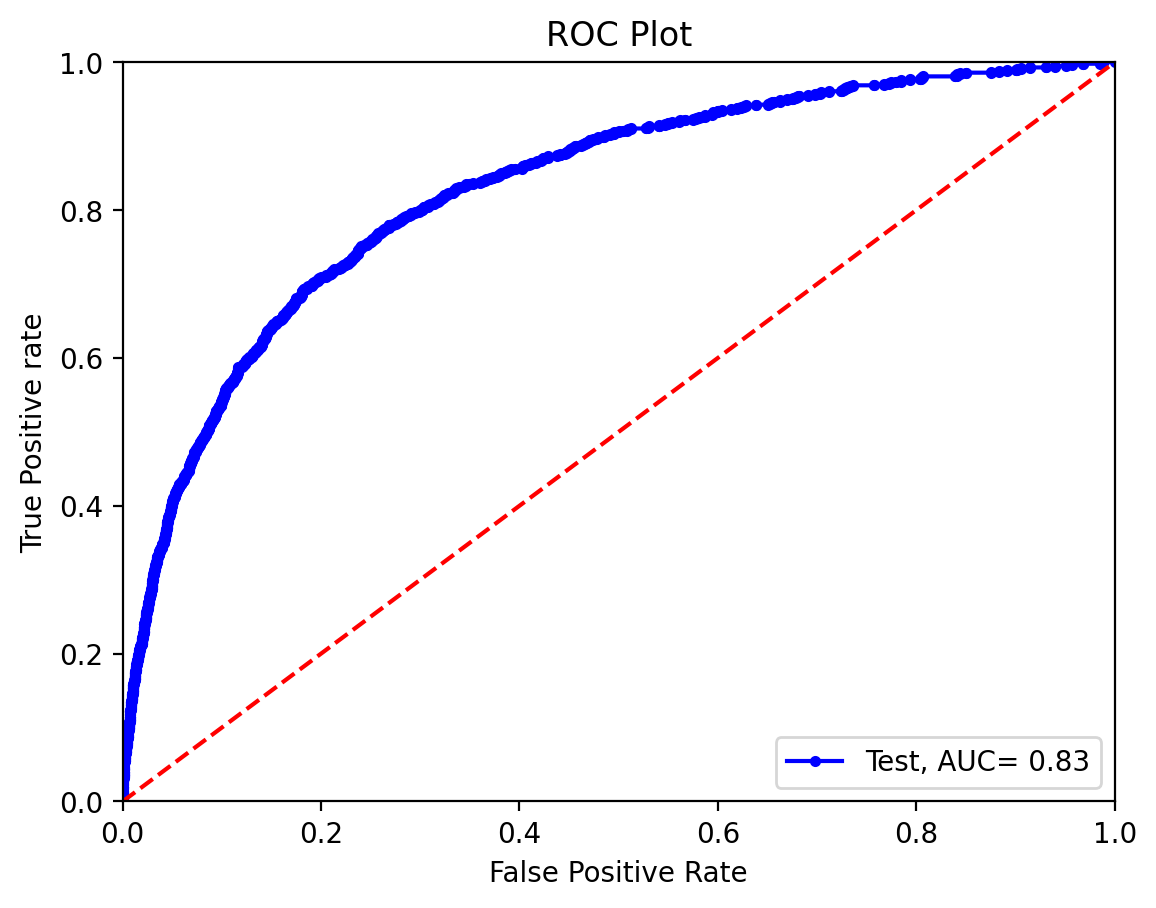

<IPython.core.display.Javascript object>

In [40]:
from diffprivlib.models import LogisticRegression as DPLR

clf_DPLR = DPLR(epsilon=epsilon, data_norm=5.026)
clf_DPLR.fit(X_train, y_train)

evaluate(clf_DPLR, X_test, y_test)

/Users/krishnakumar/opt/anaconda3/envs/cs7643-project-v1/lib/python3.8/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     89007
           1       0.00      0.00      0.00       993

    accuracy                           0.99     90000
   macro avg       0.49      0.50      0.50     90000
weighted avg       0.98      0.99      0.98     90000

ROC AUC Score 0.8277082340435312


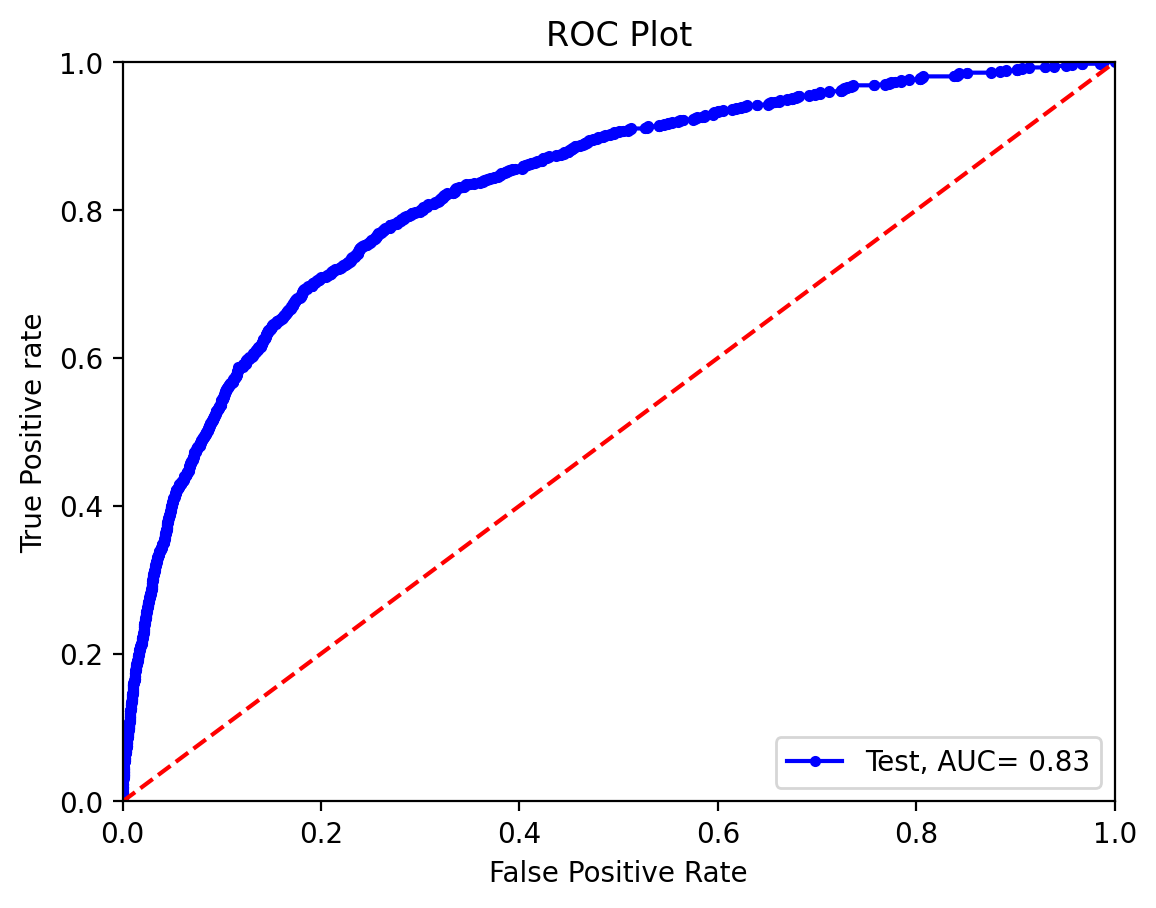

<IPython.core.display.Javascript object>

In [41]:
from diffprivlib.models import GaussianNB as DPNB

lower = list(X_train.min())
upper = list(X_train.max())
bounds = (lower, upper)

clf_DPNB = DPLR(epsilon=epsilon, bounds=bounds)
clf_DPNB.fit(X_train, y_train)

evaluate(clf_DPNB, X_test, y_test)

/Users/krishnakumar/opt/anaconda3/envs/cs7643-project-v1/lib/python3.8/site-packages/diffprivlib/models/forest.py:201: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     89007
           1       0.00      0.00      0.00       993

    accuracy                           0.99     90000
   macro avg       0.49      0.50      0.50     90000
weighted avg       0.98      0.99      0.98     90000

ROC AUC Score 0.49971912321502804


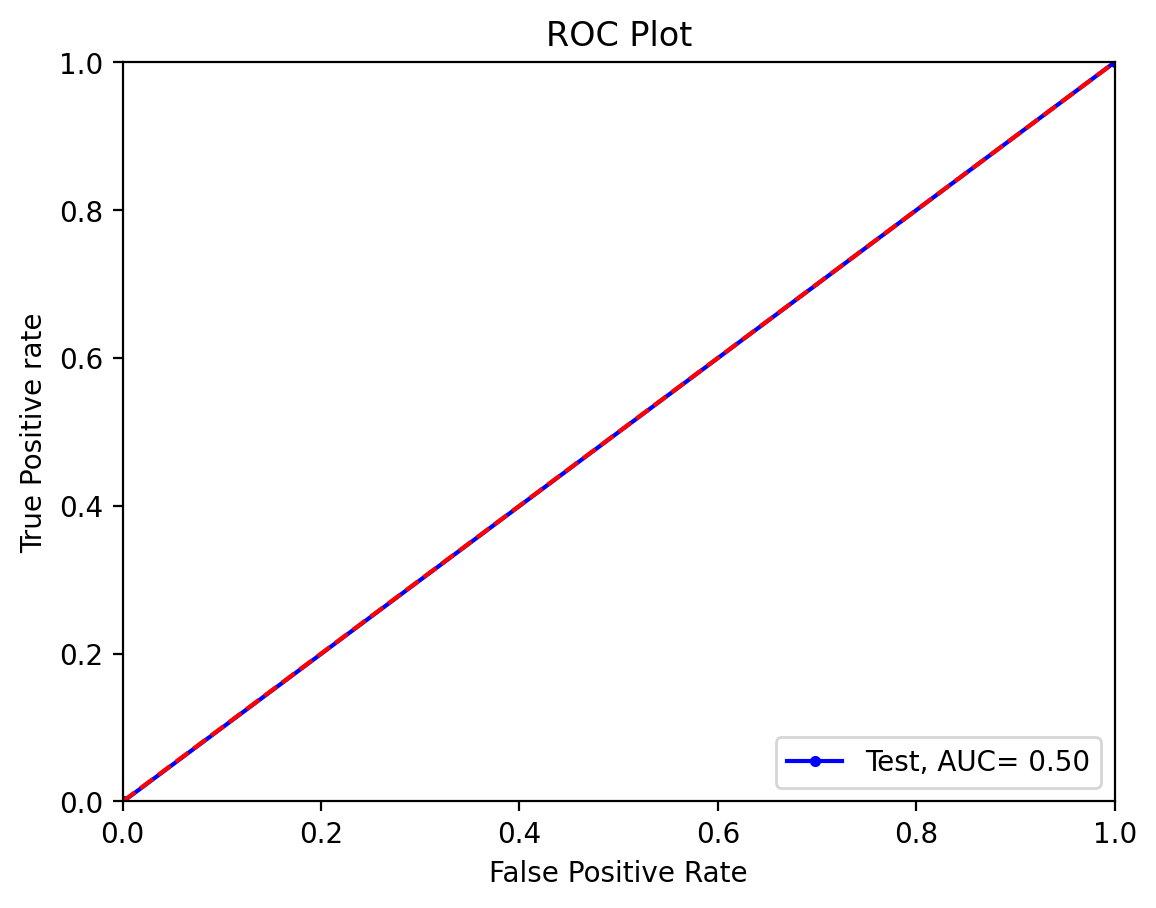

<IPython.core.display.Javascript object>

In [42]:
# Hopeless
from diffprivlib.models import RandomForestClassifier as RFNB

lower = list(X_train.min())
upper = list(X_train.max())
bounds = (lower, upper)

clf_RFNB = RFNB(epsilon=epsilon, bounds=bounds)
clf_RFNB.fit(X_train, y_train)

evaluate(clf_RFNB, X_test, y_test)


In [43]:
category_cols = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
    "fraud_bool",
]

<IPython.core.display.Javascript object>

In [44]:
# https://docs.smartnoise.org/synth/synthesizers/index.html

<IPython.core.display.Javascript object>

In [45]:
from snsynth.transform import *

tableTransformer = TableTransformer(
    [
        MinMaxTransformer(
            lower=np.floor(dfPrivate.iloc[:, i].min()),
            upper=np.ceil(dfPrivate.iloc[:, i].max()),
        )
        for i in range(dfPrivate.shape[1])
    ]
)

<IPython.core.display.Javascript object>

In [46]:
# for i in range(dfPrivate.shape[1]):
# print(i+1, dfPrivate.iloc[:, 11].max())

<IPython.core.display.Javascript object>

In [48]:
from snsynth.pytorch.nn import PATECTGAN
from snsynth.pytorch import PytorchDPSynthesizer

synth_PATE = PytorchDPSynthesizer(3.0, PATECTGAN(regularization="dragan"), None)
# synth.fit(dfPrivate, categorical_columns=category_cols)
synth_PATE.fit(dfPrivate, preprocessor_eps=1.0)
# synth_PATE.fit(dfPrivate, transformer= tableTransformer, preprocessor_eps=0.0)

sample_PATECTGAN_3 = synth_PATE.sample(dfPrivate.shape[0])  # synthesize 100 rows
print(sample_PATECTGAN_3.shape)

Spent 1.0 epsilon on preprocessor, leaving 2.0 for training
using loss cross_entropy and regularization dragan
eps: 0.189173 	 G: 3.833977 	 D: 1.176270
eps: 0.620118 	 G: 4.580109 	 D: 1.494553
eps: 0.879937 	 G: 4.363780 	 D: 1.491276
eps: 1.080481 	 G: 4.365584 	 D: 1.387190
eps: 1.250236 	 G: 4.306898 	 D: 1.556150
eps: 1.400618 	 G: 4.220931 	 D: 1.423922
eps: 1.536692 	 G: 3.991099 	 D: 1.396671
eps: 1.662492 	 G: 3.730719 	 D: 1.443460
eps: 1.779878 	 G: 3.633538 	 D: 1.274753
eps: 1.890824 	 G: 3.709408 	 D: 1.114590
eps: 1.995648 	 G: 3.465220 	 D: 1.208962
(300000, 12)


<IPython.core.display.Javascript object>

In [49]:
import pickle as pkl
import numpy as np

<IPython.core.display.Javascript object>

In [51]:
# sample_PATECTGAN
with open("data/output/sample_PATECTGAN_3.pkl", "wb") as f:
    pkl.dump(sample_PATECTGAN_3, f)

<IPython.core.display.Javascript object>

In [52]:
unpickled_PATECTGAN_3 = np.load("data/output/sample_PATECTGAN_3.pkl", allow_pickle=True)
print(unpickled_PATECTGAN_3.shape)

(300000, 12)


<IPython.core.display.Javascript object>

In [53]:
unpickled_PATECTGAN_3

,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,1,0.695159,0.409204,2,1,300.683996,2,0,0,601.025570,2,0
1,1,0.256756,0.506977,2,1,34.673607,3,1,0,872.832649,3,0
2,1,0.595771,0.549888,0,2,156.045944,5,1,0,632.278412,2,0
3,1,0.676288,0.264949,2,0,37.909986,5,1,0,886.982825,3,1
4,0,0.827748,0.618942,0,4,99.633648,1,1,1,1538.429354,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1,0.650299,0.505659,4,0,344.870445,0,1,1,722.149008,2,1
299996,0,0.718776,0.715267,4,2,175.657504,0,0,0,392.878769,4,1
299997,1,0.798823,0.299997,1,1,4.795238,2,1,0,1127.151314,1,0
299998,1,0.376556,0.484328,1,1,76.689531,3,1,0,1339.979933,0,1


<IPython.core.display.Javascript object>

In [86]:
np.save(
    "data/output/sample_PATECTGAN_3_from_v3run", sample_PATECTGAN_3, allow_pickle=True
)

<IPython.core.display.Javascript object>

In [87]:
np.savetxt(
    "data/output/sample_PATECTGAN_3_from_v3run.csv", sample_PATECTGAN_3, delimiter=","
)

<IPython.core.display.Javascript object>

In [80]:
import pandas as pd
from snsynth import Synthesizer

synth_DPCTGAN = Synthesizer.create("dpctgan", epsilon=3.0, verbose=True)
synth_DPCTGAN.fit(dfPrivate, preprocessor_eps=1.0)
# synth_DPCTGAN.fit(dfPrivate, transformer=tableTransformer, preprocessor_eps=0.0)
# sample_DPCTGAN_3 = synth_DPCTGAN.fit_sample(
# dfPrivate, transformer=tableTransformer, preprocessor_eps=0.0
# )
sample_DPCTGAN_3 = synth_DPCTGAN.sample(dfPrivate.shape[0])
print(sample_DPCTGAN_3.shape)

Spent 1.0 epsilon on preprocessor, leaving 2.0 for training
Epoch 1, Loss G: 0.6807, Loss D: 1.3875
epsilon is 0.22229275388042935, alpha is 63.0
Epoch 2, Loss G: 0.6252, Loss D: 1.3889
epsilon is 0.22659597736511938, alpha is 63.0
Epoch 3, Loss G: 0.5757, Loss D: 1.4067
epsilon is 0.23089920084980944, alpha is 63.0
Epoch 4, Loss G: 0.5252, Loss D: 1.4238
epsilon is 0.2352024243344995, alpha is 63.0
Epoch 5, Loss G: 0.4882, Loss D: 1.4491
epsilon is 0.23950564781918954, alpha is 63.0
Epoch 6, Loss G: 0.4522, Loss D: 1.4682
epsilon is 0.24380887130387957, alpha is 63.0
Epoch 7, Loss G: 0.4238, Loss D: 1.4864
epsilon is 0.2481120947885696, alpha is 63.0
Epoch 8, Loss G: 0.3953, Loss D: 1.5174
epsilon is 0.2524153182732597, alpha is 63.0
Epoch 9, Loss G: 0.3731, Loss D: 1.5511
epsilon is 0.2567185417579497, alpha is 63.0
Epoch 10, Loss G: 0.3542, Loss D: 1.5783
epsilon is 0.26102176524263976, alpha is 63.0
Epoch 11, Loss G: 0.3559, Loss D: 1.5879
epsilon is 0.26532498872732985, alpha is 6

epsilon is 0.60672021296611, alpha is 49.0
Epoch 96, Loss G: 1.7652, Loss D: 1.9290
epsilon is 0.6100639207843188, alpha is 49.0
Epoch 97, Loss G: 1.7116, Loss D: 2.0161
epsilon is 0.6134076286025274, alpha is 49.0
Epoch 98, Loss G: 1.8503, Loss D: 1.9224
epsilon is 0.6167513364207362, alpha is 49.0
Epoch 99, Loss G: 1.8042, Loss D: 2.0537
epsilon is 0.6200502362376977, alpha is 48.0
Epoch 100, Loss G: 1.8824, Loss D: 1.8695
epsilon is 0.6233254784686834, alpha is 48.0
Epoch 101, Loss G: 1.7362, Loss D: 1.8693
epsilon is 0.6266007206996692, alpha is 48.0
Epoch 102, Loss G: 1.7391, Loss D: 1.8853
epsilon is 0.6298759629306548, alpha is 48.0
Epoch 103, Loss G: 1.8235, Loss D: 1.8765
epsilon is 0.6331329153482786, alpha is 47.0
Epoch 104, Loss G: 1.8271, Loss D: 2.0527
epsilon is 0.6363397014773149, alpha is 47.0
Epoch 105, Loss G: 1.8982, Loss D: 2.0523
epsilon is 0.639546487606351, alpha is 47.0
Epoch 106, Loss G: 1.9801, Loss D: 2.1050
epsilon is 0.6427532737353872, alpha is 47.0
Epoch

Epoch 190, Loss G: 2.1054, Loss D: 2.1010
epsilon is 0.8737985624215144, alpha is 35.0
Epoch 191, Loss G: 2.1151, Loss D: 2.1200
epsilon is 0.8761846142122169, alpha is 35.0
Epoch 192, Loss G: 2.0988, Loss D: 2.1004
epsilon is 0.8785706660029194, alpha is 35.0
Epoch 193, Loss G: 2.0396, Loss D: 2.1729
epsilon is 0.8809567177936218, alpha is 35.0
Epoch 194, Loss G: 2.0983, Loss D: 2.0869
epsilon is 0.8833427695843242, alpha is 35.0
Epoch 195, Loss G: 2.0813, Loss D: 2.1063
epsilon is 0.8857288213750267, alpha is 35.0
Epoch 196, Loss G: 2.1402, Loss D: 2.0918
epsilon is 0.8881148731657292, alpha is 35.0
Epoch 197, Loss G: 2.0238, Loss D: 2.0401
epsilon is 0.8905009249564316, alpha is 35.0
Epoch 198, Loss G: 2.0254, Loss D: 2.0539
epsilon is 0.892886976747134, alpha is 35.0
Epoch 199, Loss G: 2.1098, Loss D: 2.0673
epsilon is 0.8952730285378366, alpha is 35.0
Epoch 200, Loss G: 2.0230, Loss D: 2.0235
epsilon is 0.897659080328539, alpha is 35.0
Epoch 201, Loss G: 2.0332, Loss D: 2.1144
eps

epsilon is 1.0795294649004774, alpha is 29.0
Epoch 285, Loss G: 2.0684, Loss D: 2.0904
epsilon is 1.081505660151797, alpha is 29.0
Epoch 286, Loss G: 2.0700, Loss D: 2.0616
epsilon is 1.083481855403117, alpha is 29.0
Epoch 287, Loss G: 2.0863, Loss D: 1.9951
epsilon is 1.0854580506544365, alpha is 29.0
Epoch 288, Loss G: 2.0262, Loss D: 2.0528
epsilon is 1.0874342459057564, alpha is 29.0
Epoch 289, Loss G: 2.1010, Loss D: 2.1209
epsilon is 1.089410441157076, alpha is 29.0
Epoch 290, Loss G: 2.0652, Loss D: 2.0806
epsilon is 1.091386636408396, alpha is 29.0
Epoch 291, Loss G: 2.1298, Loss D: 2.0558
epsilon is 1.0933628316597157, alpha is 29.0
Epoch 292, Loss G: 2.1051, Loss D: 2.1231
epsilon is 1.0953390269110355, alpha is 29.0
Epoch 293, Loss G: 2.0869, Loss D: 2.0265
epsilon is 1.0973152221623552, alpha is 29.0
Epoch 294, Loss G: 2.0649, Loss D: 2.1246
epsilon is 1.099291417413675, alpha is 29.0
Epoch 295, Loss G: 2.0746, Loss D: 2.0726
epsilon is 1.1012676126649947, alpha is 29.0
Epo

<IPython.core.display.Javascript object>

In [81]:
sample_DPCTGAN_3

,fraud_bool,income,name_email_similarity,payment_type,employment_status,credit_risk_score,housing_status,phone_home_valid,has_other_cards,proposed_credit_limit,device_os,keep_alive_session
0,0,0.205076,0.570507,2,0,79.386112,2,0,0,151.358994,3,1
1,0,0.078523,0.963287,3,2,152.894084,0,1,0,140.046795,3,0
2,0,0.621662,0.289701,2,0,265.595381,1,0,0,1335.821093,0,0
3,0,0.504420,0.129884,1,2,27.081291,1,1,0,330.248802,0,0
4,0,0.875664,0.048668,1,0,168.602180,0,0,0,541.123703,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,0.369375,0.649078,0,0,103.778908,2,1,1,211.822651,0,1
299996,0,0.174849,0.455214,2,0,65.355131,2,0,0,155.123470,0,0
299997,0,0.189379,0.454357,0,0,119.419577,4,1,0,469.080170,2,1
299998,0,0.304229,0.279221,1,2,198.112425,2,0,0,878.931034,0,1


<IPython.core.display.Javascript object>

In [82]:
np.save("data/output/sample_DPCTGAN_3_from_v3run", sample_DPCTGAN_3, allow_pickle=True)

<IPython.core.display.Javascript object>

In [83]:
np.savetxt(
    "data/output/sample_DPCTGAN_3_from_v3run.csv", sample_DPCTGAN_3, delimiter=","
)

<IPython.core.display.Javascript object>

In [ ]:
#
#with open('data/output/sample_DPCTGAN_3.pkl','wb') as f:
    #pkl.dump(sample_DPCTGAN_3, f)

In [56]:
def QualiNBClassifier(epsilon):
    return DPNB(epsilon=epsilon)

<IPython.core.display.Javascript object>

In [63]:
def QuailPatectganSynth(epsilon):
    return Synthesizer.create("patectgan", epsilon=epsilon, verbose=True)

<IPython.core.display.Javascript object>

In [68]:
tt = TableTransformer(
    [
        MinMaxTransformer(
            lower=np.floor(dfPrivate.iloc[:, i].min()),
            upper=np.ceil(dfPrivate.iloc[:, i].max()),
        )
        for i in range(dfPrivate.shape[1] - 1)
    ]
)


<IPython.core.display.Javascript object>

In [78]:
# Quail PATE
from snsynth.quail import QUAILSynthesizer


synth_QUAIL_PATE = QUAILSynthesizer(
    3.0,
    QuailPatectganSynth,
    QualiNBClassifier,
    "fraud_bool",
    seed=seed,
    eps_split=0.9,
    # preprocessor_eps=1.0,
)
synth_QUAIL_PATE.fit(dfPrivate, transformer=tt, verbose=True, preprocessor_eps=1.0)
# synth_QUAIL_PATE.fit(dfPrivate, verbose=True, preprocessor_eps=0.3)
sample_QUAIL_PATE_3 = synth_QUAIL_PATE.sample(dfPrivate.shape[0])
print(sample_QUAIL_PATE_3.shape)

using loss cross_entropy and regularization None
eps: 0.189173 	 G: 44.488804 	 D: 18.599117
(300000, 12)


<IPython.core.display.Javascript object>

In [79]:
with open("data/output/sample_QUAIL_PATE_3.pkl", "wb") as f:
    pkl.dump(sample_QUAIL_PATE_3, f)

<IPython.core.display.Javascript object>

In [84]:
np.save(
    "data/output/sample_QUAIL_PATE_3_from_v3run", sample_QUAIL_PATE_3, allow_pickle=True
)

<IPython.core.display.Javascript object>

In [85]:
np.savetxt(
    "data/output/sample_QUAIL_PATE_3_from_v3run.csv", sample_QUAIL_PATE_3, delimiter=","
)

<IPython.core.display.Javascript object>

In [88]:
def QuailDPctganSynth(epsilon):
    return Synthesizer.create("dpctgan", epsilon=epsilon, verbose=True)

<IPython.core.display.Javascript object>

In [89]:
# Quail DPCTGAN
from snsynth.quail import QUAILSynthesizer


synth_QUAIL_DPCT = QUAILSynthesizer(
    3.0,
    QuailDPctganSynth,
    QualiNBClassifier,
    "fraud_bool",
    seed=seed,
    eps_split=0.9,
    # preprocessor_eps=1.0,
)
synth_QUAIL_DPCT.fit(dfPrivate, transformer=tt, verbose=True, preprocessor_eps=1.0)
# synth_QUAIL_PATE.fit(dfPrivate, verbose=True, preprocessor_eps=0.3)
sample_QUAIL_DPCT_3 = synth_QUAIL_DPCT.sample(dfPrivate.shape[0])
print(sample_QUAIL_DPCT_3.shape)

Epoch 1, Loss G: 0.5979, Loss D: 1.3680
epsilon is 0.22229275388042935, alpha is 63.0
Epoch 2, Loss G: 0.5088, Loss D: 1.4451
epsilon is 0.22659597736511938, alpha is 63.0
Epoch 3, Loss G: 0.3365, Loss D: 1.6480
epsilon is 0.23089920084980944, alpha is 63.0
Epoch 4, Loss G: 0.3030, Loss D: 1.7143
epsilon is 0.2352024243344995, alpha is 63.0
Epoch 5, Loss G: 0.3975, Loss D: 1.5170
epsilon is 0.23950564781918954, alpha is 63.0
Epoch 6, Loss G: 0.3478, Loss D: 1.5430
epsilon is 0.24380887130387957, alpha is 63.0
Epoch 7, Loss G: 0.2550, Loss D: 1.7776
epsilon is 0.2481120947885696, alpha is 63.0
Epoch 8, Loss G: 0.2971, Loss D: 1.6408
epsilon is 0.2524153182732597, alpha is 63.0
Epoch 9, Loss G: 0.2931, Loss D: 1.6813
epsilon is 0.2567185417579497, alpha is 63.0
Epoch 10, Loss G: 0.2725, Loss D: 1.7778
epsilon is 0.26102176524263976, alpha is 63.0
Epoch 11, Loss G: 0.3687, Loss D: 1.6537
epsilon is 0.26532498872732985, alpha is 63.0
Epoch 12, Loss G: 0.4754, Loss D: 1.4613
epsilon is 0.26

<IPython.core.display.Javascript object>

In [92]:
np.save(
    "data/output/sample_QUAIL_DPCT_3_from_v3run", sample_QUAIL_DPCT_3, allow_pickle=True
)

<IPython.core.display.Javascript object>

In [93]:
np.savetxt(
    "data/output/sample_QUAIL_DPCT_3_from_v3run.csv", sample_QUAIL_DPCT_3, delimiter=","
)

<IPython.core.display.Javascript object>

In [ ]:
'''
# Quail DPCTGAN
from snsynth.quail import QUAILSynthesizer
synth_QUAIL_DPCT = QUAILSynthesizer(3.0, synth_DPCTGAN, clf_DPNB, "fraud_bool", seed = seed, eps_split=0.9)
#synth_QUAIL_DPCT.fit(dfPrivate, transformer= tableTransformer, preprocessor_eps=0.0)
synth_QUAIL_DPCT.fit(dfPrivate, preprocessor_eps=1.0)
sample_QUAIL_DPCT_3 = synth_QUAIL_DPCT.sample(dfPrivate.shape[0])
print(sample_QUAIL_DPCT_3.shape)
'''

In [ ]:
#with open('data/output/sample_QUAIL_DPCT_3.pkl','wb') as f:
    #pkl.dump(sample_QUAIL_DPCT_3, f)

In [ ]:
'''
from snsynth import Synthesizer
import pandas as pd


synth_MWEM = Synthesizer.create("mwem", epsilon=40.0)
sample_MWEM = synth_MWEM.fit_sample(dfPrivate, preprocessor_eps=1.0)
print(sample_MWEM.shape)
'''

In [ ]:
# Configure TableTransformer
'''
from snsynth import Synthesizer
from snsynth.transform import *

pums = pd.read_csv('data/Variant_3.csv', index_col=None) # in datasets/

tt = TableTransformer([
    MinMaxTransformer(lower=18, upper=70), # age
    ChainTransformer([LabelTransformer(), OneHotEncoder()]), # sex
    ChainTransformer([LabelTransformer(), OneHotEncoder()]), # educ
    ChainTransformer([LabelTransformer(), OneHotEncoder()]), # race
    ChainTransformer([
        ClampTransformer(lower=1),
        LogTransformer(),
        MinMaxTransformer(lower=0, upper=np.log(420000)) # income
    ]),
    ChainTransformer([LabelTransformer(), OneHotEncoder()]), # married
])

synth = Synthesizer.create('dpctgan', epsilon=1.0, verbose=True)
sample = synth.fit_sample(pums, transformer=tt, preprocessor_eps=0.0)

assert (synth.odometer.spent == (0.0, 0.0))
'''